# **Updating emulators**

Training an emulator involves learning suitable parameters from your training data; this is what defines your emulator.

When running a `Recommend` workflow it is very common to query the emulator to get a new $(x_{i}, y_{i})$ pair. This new data point could then be used to improve the emulator. Completely re-training (re-fitting the parameters according to the new data) can be inefficient and expensive if we plan to do this after adding a single data point everytime, so this is another way of including new information from this data point.

In `twinLab` this is done with the `update()` method.

In this Jupyter Notebook you will: 

1. [Create an example dataset, and train your emulator.](#1-get-and-train-an-example-dataset)
2. [Visualize your trained emulator](#2-visualize-your-trained-emulator).
3. [Find new data points from your trained emulator with `Emulator.recommend`.](#3-use-recommend-to-explore-your-emulator) 
4. [Update your emulator with recommended data points](#4-update-your-emulator-with-your-recommend-results).
5. [Visualize your updated emulator](#5-visualize-your-updated-emulator).

In [1]:
# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.13.0
          User        : michelle@digilab.co.uk
          Server      : https://nqk5pxyb32.execute-api.eu-west-2.amazonaws.com/michelle/
          Environment : /Users/michellebieger/Documents/digi/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`. 

### **1. Create an example dataset**

In this tutorial you will treat the below Forrestor function as a simulator. You'll create an example dataset using the function, which has a single input variable "x" and a single output, or response, variable "y". 

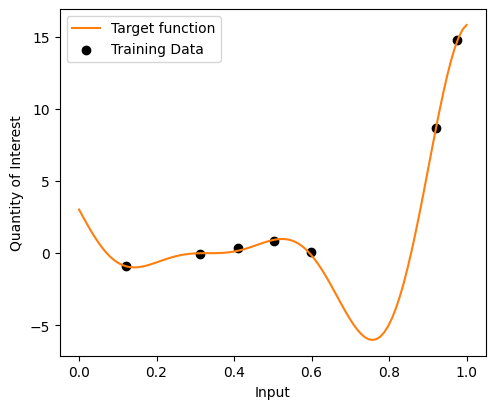

In [2]:
# Define the function - this will be used as your simulator later on
def forrester_function(x, a=6, b=12):
     return (a * x - 2) ** 2 * np.sin(b * x - 4)

X = np.linspace(0, 1, 100)
y = forrester_function(X)

# Set up your training dataframe
X_data = np.array([0.12, 0.311, 0.409, 0.502, 0.598, 0.921, 0.9765])
y_data = []
for i in X_data:
    y_data.append(forrester_function(i) + np.random.normal(scale=0.1))

# Visualize your data
plt.figure(figsize=(5.5, 4.5))
# Plot the modelled function 
plt.plot(X, y, color="tab:orange", label="Target function")
# Plot the training data 
plt.scatter(X_data, y_data, color="k", label="Training Data")

plt.xlabel("Input")
plt.ylabel("Quantity of Interest")

# Make sure to add a legend
plt.legend()
plt.show()

Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account. 

In [3]:
# Convert to DataFrame
df_train = pd.DataFrame({"x": X_data, "y": y_data})

# Initialise a Dataset object and give it a name
dataset = tl.Dataset("forrester_function")

# Upload the dataset, passing in the dataframe
dataset.upload(df_train)

Next, you need to define your emulator. 

In [4]:
# Initialise emulator
emulator_id = "forrester_function_emulator"

emulator = tl.Emulator(id=emulator_id)

When you want to train a model, you pass on your training requirements via arguments using a `TrainParams` object. `TrainParams` is a class that contains all the necessary parameters needed to train your model.

The `TrainParams` object has a lot of other parameters to customise your training including dimensionality reduction, type of estimator, automatic model selection and many others. Refer to the [twinLab-docs](https://twinlab.ai/python/reference/parameters.html#api-parameters) for more information.

In [5]:
# Define the training parameters for your emulator
params = tl.TrainParams(train_test_ratio=1.0)

Then, to train your model, you use the `Emulator.train` function, and input your `TrainParams` object as an argument to this function. 

In this example, we will just define the `train_test_ratio` parameter, which specifies the amount of data that has to be allocated to emulator training from your entire dataset.

In [6]:
# Train the emulator using the train method
emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=params, verbose=True
)

Emulator 'forrester_function_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator forrester_function_emulator is complete!


### **2. Visualize your trained emulator**

We can use the `Emulator.plot` functionality to plot the mean prediction and the uncertainty band of the emulator.

The `Emulator.plot` function internally uses the `Emulator.predict` function, so we are also predicting by calling this. There are a few arguments that can be passed to the `Emulator.predict` function, which can be done using the `tl.PredictParams` object. Refer to the [twinLab Parameter Docs](https://twinlab.ai/python/reference/parameters.html#api-parameters) for more information on the parameter objects.

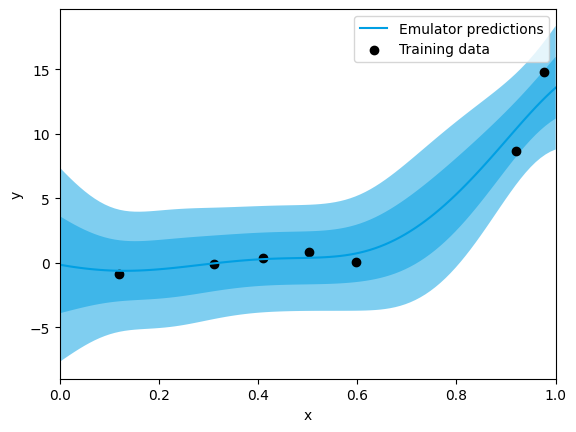

In [7]:
# Plot the trained emulator with the predictions
plt = emulator.plot(x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1))
# Add on your training data points 
plt.scatter(df_train["x"], df_train["y"], color="k", label="Training data",zorder=1)
# Make sure to add a legend
plt.legend()
plt.show()

If you check on the processes associated with your emulator, you can see the prediction that you created when using `emulator.plot`.

In [8]:
emulator.list_processes()

['predict-mini-tundra-fanatic']

You can get the results of the prediction that was made by taking the `'process_id'` generated during the plot function running and running it through `emulator.get_process`.

In [10]:
# process_id = "<INSERT-PROCESS-ID-HERE>"
process_id = "predict-mini-tundra-fanatic"
mean, std = emulator.get_process(process_id=process_id,verbose=True)

Mean predictions:
            y
0   -0.140910
1   -0.208113
2   -0.270950
3   -0.329171
4   -0.382537
..        ...
95  12.058046
96  12.462776
97  12.852374
98  13.224950
99  13.578967

[100 rows x 1 columns]
Standard deviation predictions:
           y
0   3.768722
1   3.600836
2   3.437955
3   3.281368
4   3.132435
..       ...
95  2.128283
96  2.165469
97  2.222442
98  2.298828
99  2.393599

[100 rows x 1 columns]
Process predict-mini-tundra-fanatic results:
(            y
0   -0.140910
1   -0.208113
2   -0.270950
3   -0.329171
4   -0.382537
..        ...
95  12.058046
96  12.462776
97  12.852374
98  13.224950
99  13.578967

[100 rows x 1 columns],            y
0   3.768722
1   3.600836
2   3.437955
3   3.281368
4   3.132435
..       ...
95  2.128283
96  2.165469
97  2.222442
98  2.298828
99  2.393599

[100 rows x 1 columns])


### **3. Use recommend to "explore" your emulator**

Optimise your emulator starting with just the default Recommend parameters so you can see how best to use the function. 

Utilising the default `verbose` keyword argument, and putting `wait` as `False` can be helpful if you're waiting on a longer job, as you don't need to wait until the job has finished running on `twinLab` cloud. Instead, you could carry on executing other cells. 

In [11]:
recommend_process_id = emulator.recommend(num_points=2, acq_func="explore", wait=False, verbose=True)

Job recommend process ID: recommend-melted-dust-mozzarella


To then check on the progress of your job, you can use `list_processes_statuses` to see what the status of your inference method is until it finishes. 

In [12]:
emulator.list_processes_statuses()

[{'process_id': 'predict-mini-tundra-fanatic',
  'status': 'success',
  'start_time': '2024-09-24T14:00:49.553045+00:00',
  'end_time': '2024-09-24T14:00:50.761947+00:00'},
 {'process_id': 'recommend-melted-dust-mozzarella',
  'status': 'success',
  'start_time': '2024-09-24T14:01:04.612946+00:00',
  'end_time': '2024-09-24T14:01:06.275094+00:00'}]

Using `"explore"` has returned two objects--two new recommended samples and the acquisition value. These two new recommended samples are suggested input values that would result in the greatest reduction in the overall uncertainty in the predictions from your emulator. 

### **4. Update your emulator with your `recommend` results**

Let's condition your emulator on the new data points. 

You can get the candidate points from the `recommend` process by using the `get_process` method.

In [13]:
candidate_points, acq_funcion_value = emulator.get_process(recommend_process_id)

We can then turn these candidate points into new data points by evaluating the simulator at these points. and turning them into a new training data dataframe.

In [14]:
# Feed the candidate points to the simulator
new_y_data = forrester_function(candidate_points.values.flatten())

# Convert the new data to a DataFrame
new_y_df = pd.DataFrame({"y": new_y_data})

# Combine the candidate points with the simulator results to create a new training dataframe
new_training_data = pd.concat([new_y_df, candidate_points], axis=1)

display(new_training_data)

,y,x
0,-6.008862,0.761935
1,-0.900064,0.120000


Let's condition the emulator on these new data points using the `update` method. This method updates your emulator stored in the cloud so that next time you use it for inference, it will be conditioned on the new data points.

In [15]:
emulator.update(new_training_data,wait=False)

TypeCheckError: the return value (str) is not None

### **5. Visualize your updated emulator**

In [ ]:
# Plot the updated emulator with the predictions
plt = emulator.plot(x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1))

# Add on your training data points 
plt.scatter(df_train["x"], df_train["y"], color="k", label="Training data",zorder=1)

# Add greenlines to show the recommended points
for x in range(len(new_training_data)): 
    # Plot recommendation "x points" as vertical lines
    plt.axvline(x=new_training_data['x'].iloc[x], color="#7DB928",zorder=3)

# Make sure to add a legend
plt.legend()
plt.show()

### **Deleting datasets and emulators**

You can delete your datasets and emulators to keep your `twinLab` cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up. 

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.

In [ ]:
# Delete dataset
dataset.delete()

# Delete emulator
emulator.delete()